# Federated SGD

Federated Learning proposed by [(McMahan et al., 2016)](https://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf), where a group of clients train on their own local datasets and transmit parameter updates to a central server.

In FedSGD, each client performs a single forward-backward pass on the entire local data, computes the gradients and then send them to the server for aggregation.
The server performs a simple SGD update with the clients' gradients and copies its new parameters to each client.

In this notebook, instead of a doing a full epoch at once, the clients are trained with a single batch of its local dataset. This was done for speed purposes.

In [2]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from utils import *

# 1. Downloading MNIST data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Number of training samples: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 295kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Number of training samples: 60000
Number of test samples: 10000


# 2. Separating training data to each client

In [4]:
n_clients = 3

# Specify lengths for the splits
lengths = len(train_dataset) // n_clients
splits = [lengths] * n_clients 

# Split the dataset
train_datasets = random_split(train_dataset, splits)
print(f"Number of training samples per client: {[len(dataset) for dataset in train_datasets]}")

# # Now you can create DataLoaders for each subset if needed:
train_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in train_datasets]

Number of training samples per client: [20000, 20000, 20000]


# 3. Defining architecture that will be used for all participants

In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
            )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.sequential(x)

    def backprop(self, grad_output):
        # Dummy backward pass
        grad_input = torch.autograd.grad(outputs=self.fc.weight, inputs=self.fc.weight, grad_outputs=grad_output)
        return grad_input

# 4. Initializing clients and server

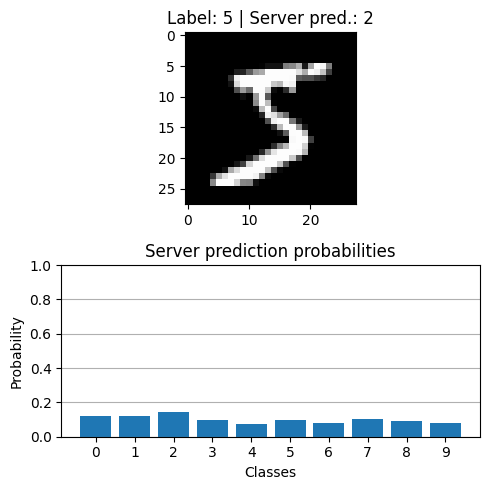

In [6]:
torch.manual_seed(42)

server = Model()
clients = [Model() for _ in range(n_clients)]
copy_global(server, clients) # copying global model to clients

fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

# 5. Training loop
- each model is trained on a single batch
- the generated param grad is sent to the global model
- the global model runs a simple GD step using the mean of all grads (FedSGD)
- the global params are copied to the clients

In [7]:
n_iters = 1000
n_params = len(get_params(server))
lr = 0.1
optimizers = [torch.optim.SGD(client.parameters(), lr=0.01) for client in clients]
loss_func = torch.nn.CrossEntropyLoss()

results = []

for i in tqdm(range(n_iters)):

    copy_global(server, clients)

    grads = torch.zeros(n_clients, n_params)

    # Optimizing clients for 1 batch
    for k, client in enumerate(clients):

        client.train()

        # Get a single batch of data
        data,target = next(iter(train_loaders[k]))

        # Batch is fed to the client
        output = client(data)

        # loss is calculated
        loss = loss_func(output, target)

        # loss gradient to each param is calculated
        optimizers[k].zero_grad()
        loss.backward()

        # gradients are collected
        grads[k] = get_grads(client).detach().view(-1)

    # Update server parameters
    k = 0
    for j, param in enumerate(server.parameters()):
        param.data -= lr*grads[:, k:k + param.numel()].mean(dim=0).view(param.shape)
        k = k + param.numel()

    # Evaluate server every K iterations
    if (i+1) % 100 == 0:
        print(f'Iteration {i+1}/{n_iters} | Server eval: {evaluate(server, test_loader)}')

 10%|█         | 104/1000 [00:03<01:00, 14.93it/s]

Iteration 100/1000 | Server eval: 0.83


 20%|██        | 205/1000 [00:05<00:39, 19.90it/s]

Iteration 200/1000 | Server eval: 0.8803


 31%|███       | 306/1000 [00:08<00:34, 20.13it/s]

Iteration 300/1000 | Server eval: 0.9092


 40%|████      | 405/1000 [00:11<00:33, 17.97it/s]

Iteration 400/1000 | Server eval: 0.9035


 51%|█████     | 506/1000 [00:14<00:22, 21.79it/s]

Iteration 500/1000 | Server eval: 0.934


 61%|██████    | 606/1000 [00:16<00:19, 20.65it/s]

Iteration 600/1000 | Server eval: 0.9382


 71%|███████   | 709/1000 [00:19<00:13, 21.17it/s]

Iteration 700/1000 | Server eval: 0.9381


 81%|████████  | 809/1000 [00:22<00:08, 22.37it/s]

Iteration 800/1000 | Server eval: 0.9393


 90%|█████████ | 904/1000 [00:24<00:05, 18.55it/s]

Iteration 900/1000 | Server eval: 0.9475


100%|██████████| 1000/1000 [00:27<00:00, 36.36it/s]

Iteration 1000/1000 | Server eval: 0.9486


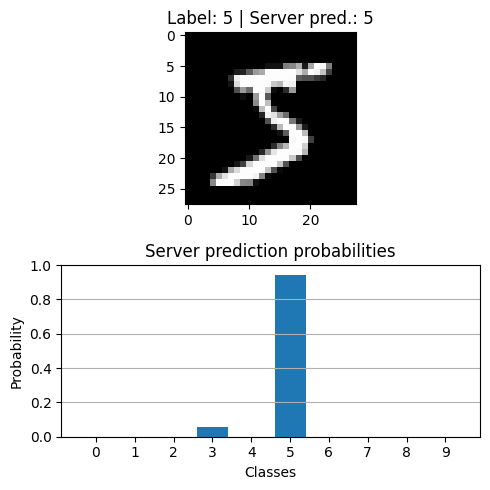

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()